In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

### Control Variables

In [2]:
SAVE_MODEL = False
TRAIN_MODEL = True

In [18]:
digits = load_digits()
X, y = digits.data, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape)
print(X_train.dtype)
print(y_train[:5])

(1437, 64) (360, 64)
float64
[4 8 8 1 7]


### Find best model

In [4]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, accuracy_score

In [5]:
classifiers = []

f1_scorer = make_scorer(f1_score, average="macro")

### Support Vector Machine

In [6]:
# no pipeline because no need to scale the inputs
param_grid = [
    {'C': [1, 10, 100, 1000], 'tol': [0.001, 0.0001], 
     'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'tol': [0.001, 0.0001], 
     'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
    {'C': [1, 10, 100, 1000], 'tol': [0.001, 0.0001], 
     'kernel': ['poly'], 'degree': [3, 4, 5]}
]

TRAIN_MODEL = True
if TRAIN_MODEL:
    svc = GridSearchCV(
        estimator=SVC(),
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=3
    )

    svc.fit(X_train, y_train)
    classifiers.append(("svc", svc.best_estimator_))
    print(svc.best_estimator_)
    print(svc.best_score_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
0.9901400721998277


### Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
logit_pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("logit", LogisticRegression(max_iter=300, n_jobs=-1))
])

param_grid = [
    {"logit__penalty": ["l2"]},
    {"logit__penalty": ["elasticnet"], 
     "logit__l1_ratio": [0.25, 0.5, 0.75], "logit__solver": ["saga"]}
]


TRAIN_MODEL = True
if TRAIN_MODEL:
    del classifiers[1:] # this is so the list doesn't get super long when testing different clfs
    
    logit_gs = GridSearchCV(
        estimator=logit_pipe,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=3
    )

    logit_gs.fit(X_train, y_train)
    classifiers.append(("logit", logit_gs.best_estimator_))
    print(logit_gs.best_estimator_)
    print(logit_gs.best_score_)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logit',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=300,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)
0.9627965575069842


### Random Forests Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
param_grid = [
    {"max_depth": [50, 100, 150], "min_impurity_decrease": [1.0e-9, 1.0e-8, 1.0e-7, 1.0e-6]}
]

TRAIN_MODEL = True
if TRAIN_MODEL:
    del classifiers[2:] # this is so the list doesn't get super long when testing different clfs
    
    forest_gs = GridSearchCV(
        estimator=RandomForestClassifier(n_jobs=-1),
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=3
    )


    forest_gs.fit(X_train, y_train)
    classifiers.append(("forest", forest_gs.best_estimator_))
    print(forest_gs.best_estimator_)
    print(forest_gs.best_score_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=1e-08, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.976012943010069


### Ensemble classifier

In [11]:
print(len(classifiers))

3


In [12]:
from sklearn.ensemble import VotingClassifier

In [13]:
clf = VotingClassifier(estimators=classifiers, voting="hard", n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred, average="macro"))

Accuracy: 0.9944444444444445
F1 score: 0.9950843029189629


In [16]:
from sklearn.metrics import plot_confusion_matrix

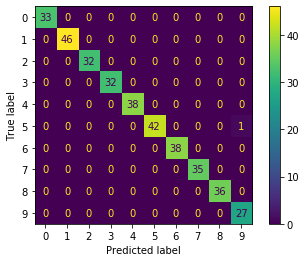

In [17]:
class_names = digits.target_names
disp = plot_confusion_matrix(clf, X_test, y_test, display_labels=class_names)

In [19]:
SAVE = False
if SAVE:
    import pickle
    with open("clf.pickle", "wb") as f:
        pickle.dump(clf, f)